In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

# Bijectors and normalising flows

 ## Coding tutorials
 #### [1. Bijectors](#coding_tutorial_1)
 #### [2. The TransformedDistribution class](#coding_tutorial_2)
 #### [3. Subclassing bijectors](#coding_tutorial_3)
 #### [4. Normalising flows](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Bijectors

In [3]:
# Define base distribution

normal = tfd.Normal(loc=0, scale=1)

In [4]:
# Sample from base distribution

n = 10000
z = normal.sample(n)

### Scale and shift bijector

In [18]:
# Define scale and shift
shift_val = 4.5
scale_val = 7

scale = tfb.Scale(scale_val)
shift = tfb.Shift(shift_val)

In [21]:
# Define chain bijector

scale_shift_chain = tfb.Chain([shift, scale])

In [22]:
# We can also use call methods

scale_transf = tfb.Scale(scale_val)
shift_transf = tfb.Shift(shift_val)
scale_shift_call = shift_transf(scale_transf)

In [23]:
# Apply the forward transformation

x_call = scale_shift_call.forward(z)
x_chain = scale_shift_chain.forward(z)

In [27]:
# Check the forward transformation

print(tf.norm(x_call - (scale_val*z + shift_val)))
print(tf.norm(x_chain - (scale_val*z + shift_val)))

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


#### Plots

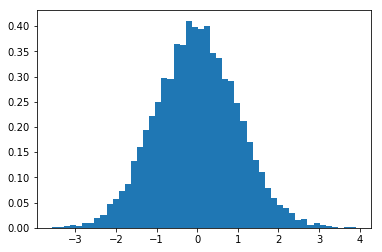

In [34]:
# Plot z density

plt.hist(z, bins=50, density=True)
plt.show()

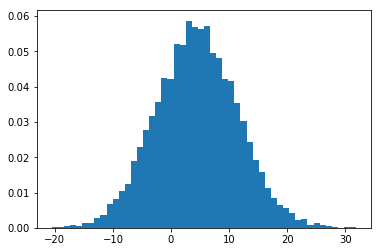

In [36]:
# Plot x density

plt.hist(x_call, bins=50, density=True)
plt.show()

#### Inverse transformation

In [38]:
# Apply inverse transformation

inv_x_call = scale_shift_call.inverse(x_call)
inv_x_chain = scale_shift_chain.inverse(x_chain)

In [39]:
# Check inverse transformation

print(tf.norm(inv_x_call - z))
print(tf.norm(inv_x_chain - z))

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


#### Log probability

In [40]:
# Compute log prob for x

log_prob_x_call = normal.log_prob(z) - scale_shift_call.forward_log_det_jacobian(z, event_ndims=0)
log_prob_x_chain = normal.log_prob(z) - scale_shift_chain.forward_log_det_jacobian(z, event_ndims=0)

In [42]:
# We can also use the inverse transformation

log_prob_x_call = normal.log_prob(z) + scale_shift_call.inverse_log_det_jacobian(z, event_ndims=0)
log_prob_x_chain = normal.log_prob(z) + scale_shift_chain.inverse_log_det_jacobian(z, event_ndims=0)

### Broadcasting

In [55]:
x = tf.random.normal(shape=(100, 1))

In [56]:
# Softfloor bijector

softfloor = tfb.Softfloor(temperature=0.01)
y = softfloor.forward(x)
print(y.shape)

(100, 1)


In [57]:
# Softfloor bijector using broadcasting

softfloor_2 = tfb.Softfloor(temperature=[0.2, 1])
y = softfloor_2.forward(x)
print(y.shape)

(100, 2)


In [58]:
# Softfloor bijector using broadcasting

softfloor_3 = tfb.Softfloor(temperature=[0.01, 0.1, 1])

In [59]:
# Plot routine

def _plot(nparams, bijector, params, x):
    bijector_params = tuple(getattr(bijector, name) for name in params)
    upper_params = [name[0].upper() + name[1:] for name in params]
    fig = plt.figure(figsize=(14, 5))
    lines = plt.plot(np.tile(x, nparams), bijector.forward(x))
    for l in zip(lines, *bijector_params):
        labels = ": {:.2f}, ".join(upper_params) + ': {:.2f}'
        l[0].set_label(labels.format(*l[1:]))
    plt.legend()
    plt.show()

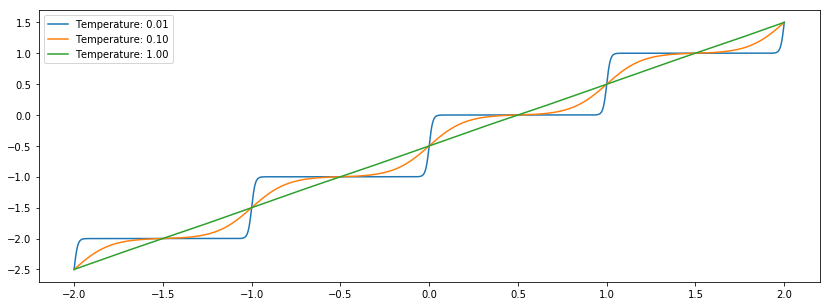

In [60]:
# Plot

x = np.linspace(-2, 2, 2000)[..., np.newaxis]
_plot(2, softfloor_3, ['temperature'], x)

In [64]:
# Gumbel bijector using broadcasting

exps = tfb.GumbelCDF(loc=[0.5, 1, 1.5, 2, 3], scale=[1, 2, 2, 3, 4])

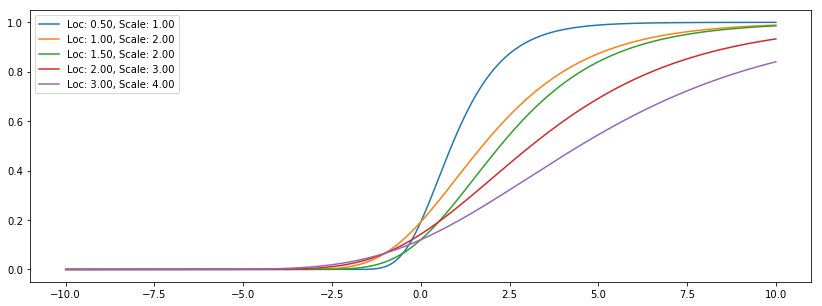

In [67]:
# Plot

x = np.linspace(-10, 10, 2000, dtype=np.float32)[..., np.newaxis]
_plot(5, exps, ['loc', 'scale'], x)

***
<a id="coding_tutorial_2"></a>
## The TransformedDistribution class

### TransformedDistribution

In [68]:
# Parameters

n = 10000
loc = 0
scale = 0.5

In [69]:
# Normal distribution

normal = tfd.Normal(loc=loc, scale=scale)

In [70]:
# Display event and batch shape

print('batch shape: ', normal.batch_shape)
print('event shape: ', normal.event_shape)

batch shape:  ()
event shape:  ()


In [71]:
# Exponential bijector

exp = tfb.Exp()

In [72]:
# Log normal transformed distribution using exp and normal bijectors

log_normal_td = exp(normal)

In [73]:
# Display event and batch shape

print('batch shape: ', log_normal_td.batch_shape)
print('event shape: ', log_normal_td.event_shape)

batch shape:  ()
event shape:  ()


In [74]:
# Base distribution

z = normal.sample(n)
z

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([-0.06725186, -0.18744272,  0.70336896, ..., -0.6357728 ,
       -0.3082752 , -0.64688355], dtype=float32)>

#### Plots

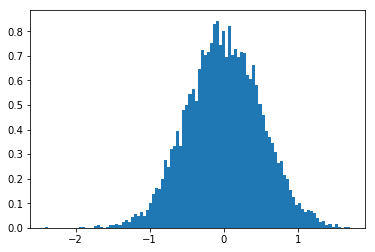

In [75]:
# Plot z density

plt.hist(z, bins=100, density=True)
plt.show()

In [76]:
# Transformed distribution

x = log_normal_td.sample(n)

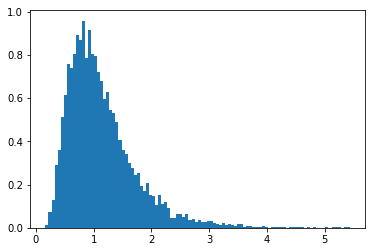

In [77]:
# Plot x density

plt.hist(x, bins=100, density=True)
plt.show()

In [78]:
# Define log normal distribution

log_normal = tfd.LogNormal(loc=loc, scale=scale)

In [79]:
# Sample log_normal

l = log_normal.sample(n)

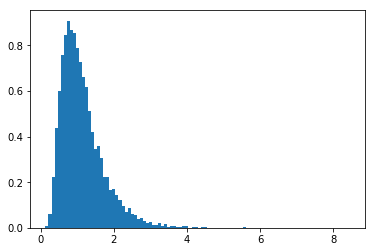

In [80]:
# Plot l density

plt.hist(l, bins=100, density=True)
plt.show()

#### Log probability

In [81]:
# Log prob of LogNormal

log_prob = log_normal.log_prob(x)

In [82]:
# Log prob of log normal transformed distribution

log_prob_td = log_normal_td.log_prob(x)

In [83]:
# Check log probs

tf.norm(log_prob - log_prob_td)

<tf.Tensor: shape=(), dtype=float32, numpy=7.0458386e-06>

### Event shape and batch shape

In [85]:
# Set a scaling lower triangular matrix

tril = tf.random.normal((2,4,4))
scale_low_tri = tf.linalg.LinearOperatorLowerTriangular(tril)
tril

<tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[ 1.1498325 , -0.7882303 , -1.1228223 , -1.4748063 ],
        [ 1.0599825 , -0.19253768, -0.01596493,  0.5253946 ],
        [ 0.29360333,  0.02473716,  0.00534782, -0.99984634],
        [ 0.8248432 ,  0.30259827,  0.93248326, -0.061167  ]],

       [[-0.41180596, -1.2212152 ,  1.2994511 , -1.5836107 ],
        [-1.644247  , -1.7496502 ,  0.1179924 ,  1.154259  ],
        [ 1.030067  ,  0.2762616 , -0.74587846,  0.06132296],
        [ 0.30130687, -0.95928144,  1.2509154 , -1.8272067 ]]],
      dtype=float32)>

In [92]:
# View of scale_low_tri

scale_low_tri.to_dense()

<tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[ 1.1498325 ,  0.        ,  0.        ,  0.        ],
        [ 1.0599825 , -0.19253768,  0.        ,  0.        ],
        [ 0.29360333,  0.02473716,  0.00534782,  0.        ],
        [ 0.8248432 ,  0.30259827,  0.93248326, -0.061167  ]],

       [[-0.41180596,  0.        ,  0.        ,  0.        ],
        [-1.644247  , -1.7496502 ,  0.        ,  0.        ],
        [ 1.030067  ,  0.2762616 , -0.74587846,  0.        ],
        [ 0.30130687, -0.95928144,  1.2509154 , -1.8272067 ]]],
      dtype=float32)>

In [93]:
# Define scale linear operator

scale_lin_op = tfb.ScaleMatvecLinearOperator(scale_low_tri)

In [94]:
# Define scale linear operator transformed distribution with a batch and event shape

mvn = tfd.TransformedDistribution(normal, scale_lin_op, batch_shape=[2], event_shape=[4])
print(mvn)

tfp.distributions.TransformedDistribution("scale_matvec_linear_operatorNormal", batch_shape=[2], event_shape=[4], dtype=float32)


In [95]:
# Display event and batch shape

print('Batch shape: ', mvn.batch_shape)
print('Event shape: ', mvn.event_shape)

Batch shape:  (2,)
Event shape:  (4,)


In [99]:
# Sample

y1 = mvn.sample(sample_shape=(n,))
print(yl.shape)

(10000, 2, 4)


In [97]:
# Define a MultivariateNormalLinearOperator distribution

mvn2 = tfd.MultivariateNormalLinearOperator(loc=0, scale=scale_low_tri)
print(mvn2)

tfp.distributions.MultivariateNormalLinearOperator("MultivariateNormalLinearOperator", batch_shape=[2], event_shape=[4], dtype=float32)


In [98]:
# Display event and batch shape

print('Batch shape: ', mvn2.batch_shape)
print('Event shape: ', mvn2.event_shape)

Batch shape:  (2,)
Event shape:  (4,)


In [100]:
# Sample

y2 = mvn2.sample(sample_shape=(n,))
print(y2.shape)

(10000, 2, 4)


In [101]:
# Check

xn = normal.sample((n,2,4))
tf.norm(mvn.log_prob(xn) - mvn2.log_prob(xn)) / tf.norm(mvn.log_prob(xn))

<tf.Tensor: shape=(), dtype=float32, numpy=0.7500003>

***
<a id="coding_tutorial_3"></a>
## Subclassing bijectors

In [19]:
# Define a new bijector: Cubic

class Cubic(tfb.Bijector):

    def __init__(self, a, b, validate_args=False, name='Cubic'):
        self.a = tf.cast(a, tf.float32)
        self.b = tf.cast(b, tf.float32)
        if validate_args:
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.a), 1e-5), tf.float32)) == 1.0
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.b), 1e-5), tf.float32)) == 1.0
        super(Cubic, self).__init__(validate_args=validate_args, forward_min_event_ndims=0, name=name)
    
    def _forward(self, x):
        x = tf.cast(x, tf.float32)
        forward = tf.squeeze(tf.pow(self.a * x + self.b, 3))
        return forward
    
    def _inverse(self, y):
        y = tf.cast(y, tf.float32)
        inverse = (tf.math.sign(y) * tf.pow(tf.abs(y), 1/3) - self.b) / self.a
        return inverse
    
    def _forward_log_det_jacobian(self, x):
        x = tf.cast(x, tf.float32)
        forward_jacob = tf.math.log(3 * tf.abs(self.a)) + 2 * tf.math.log(tf.abs(self.a * x + self.b))
        return forward_jacob


In [23]:
# Cubic bijector

cubic = Cubic([1.0, -2.0], [-1.0, 0.4], validate_args=True)

In [24]:
# Apply forward transformation

x = tf.constant([[1, 2], [3, 4]])
y = cubic.forward(x)
print(y)

tf.Tensor(
[[   0.        -46.655994]
 [   8.       -438.97598 ]], shape=(2, 2), dtype=float32)


In [25]:
# Check inverse

np.linalg.norm(x - cubic.inverse(y))

0.0

#### Function plots

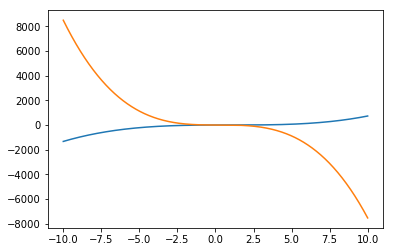

In [27]:
# Plot the forward transformation

x = np.linspace(-10, 10, 500).reshape(-1, 1)
plt.plot(x, cubic.forward(x))

In [28]:
# Display shape

cubic.forward(x).shape

TensorShape([500, 2])

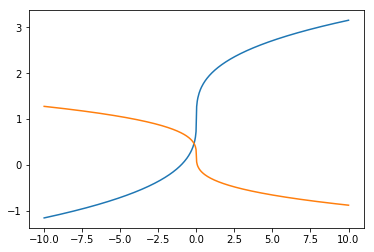

In [29]:
# Plot the inverse

plt.plot(x, cubic.inverse(x))

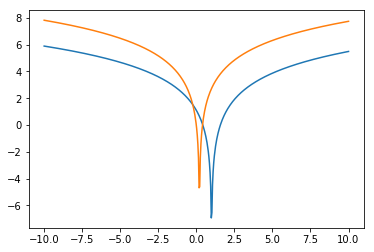

In [30]:
# Plot the forward log Jacobian determinant

plt.plot(x, cubic.forward_log_det_jacobian(x, event_ndims=0))

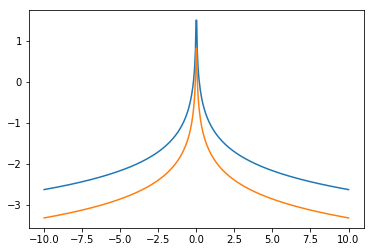

In [32]:
# Plot the inverse log Jacobian determinant

plt.plot(x, cubic.inverse_log_det_jacobian(x, event_ndims=0))

#### TransformedDistribution and plots

In [34]:
# Create a transformed distribution with Cubic

normal = tfd.Normal(loc=0, scale=1)
cubed_normal = tfd.TransformedDistribution(normal, cubic, event_shape=[2])

In [35]:
# Sample cubed_normal

n = 1000
g = cubed_normal.sample(n)
g.shape

TensorShape([1000, 2])

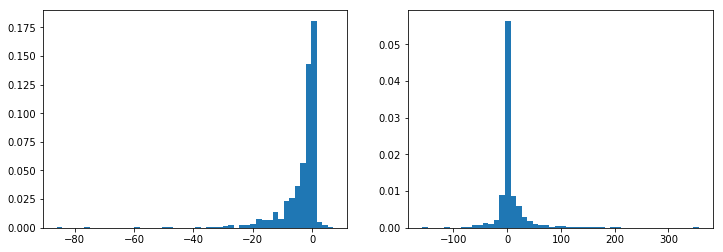

In [36]:
# Plot histograms

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(g[..., 0], bins=50, density=True)
plt.subplot(1, 2, 2)
plt.hist(g[..., 1], bins=50, density=True)
plt.show()

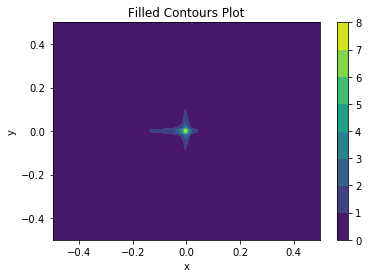

In [37]:
# Make contour plot

xx = np.linspace(-0.5, 0.5, 100)
yy = np.linspace(-0.5, 0.5, 100)
X, Y = np.meshgrid(xx, yy)

fig,ax=plt.subplots(1,1)
Z = cubed_normal.prob(np.dstack((X, Y)))
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [38]:
# Create a transformed distribution with the inverse of Cube

inverse_cubic = tfb.Invert(cubic)
inv_cubed_normal = inverse_cubic(normal, event_shape=[2])

In [39]:
# Samble inv_cubed_normal

n = 1000
g = inv_cubed_normal.sample(n)
g.shape

TensorShape([1000, 2])

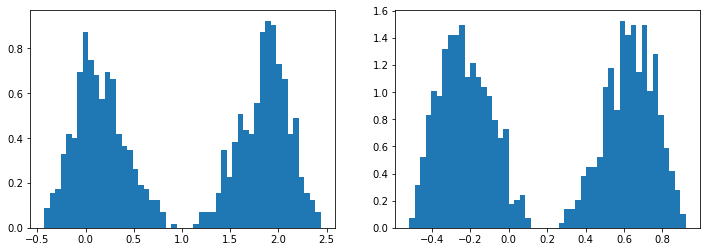

In [41]:
# Plot histograms

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(g[..., 0], bins=50, density=True)
plt.subplot(1, 2, 2)
plt.hist(g[..., 1], bins=50, density=True)
plt.show()

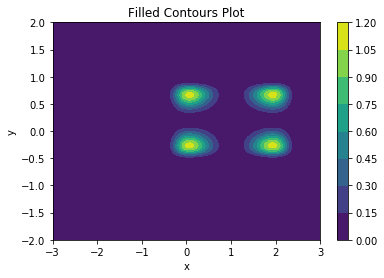

In [40]:
# Make contour plot

xx = np.linspace(-3.0, 3.0, 100)
yy = np.linspace(-2.0, 2.0, 100)
X, Y = np.meshgrid(xx, yy)

fig,ax=plt.subplots(1,1)
Z = inv_cubed_normal.prob(np.dstack((X, Y)))
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

#### Training the bijector

In [42]:
# Create a mixture of four Gaussians

probs = [0.45, 0.55]

mix_gauss = tfd.Mixture(
    cat=tfd.Categorical(probs=probs),
    components=[
        tfd.Normal(loc=2.3, scale=0.4),
        tfd.Normal(loc=-.8, scale=0.4)
    ]
)

In [43]:
# Create the dataset

x_train = mix_gauss.sample(10000)
x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_train = x_train.batch(128)

x_valid = mix_gauss.sample(1000)
x_valid = tf.data.Dataset.from_tensor_slices(x_valid)
x_valid = x_valid.batch(128)

print(x_train.element_spec)
print(x_valid.element_spec)

TensorSpec(shape=(None,), dtype=tf.float32, name=None)
TensorSpec(shape=(None,), dtype=tf.float32, name=None)


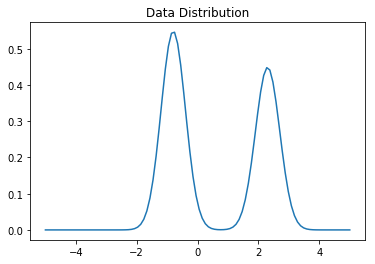

In [44]:
# Plot the data distribution

x = np.linspace(-5, 5, 100)
plt.plot(x, mix_gauss.prob(x))
plt.title('Data Distribution')
plt.show()

In [59]:
# Make a trainable bijector

trainable_inv_cubic = tfb.Invert(Cubic(tf.Variable(0.25), tf.Variable(-0.1)))
trainable_inv_cubic.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.25>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.1>)

In [60]:
# Make a trainable transformed distribution

trainable_dist = tfd.TransformedDistribution(normal, trainable_inv_cubic)

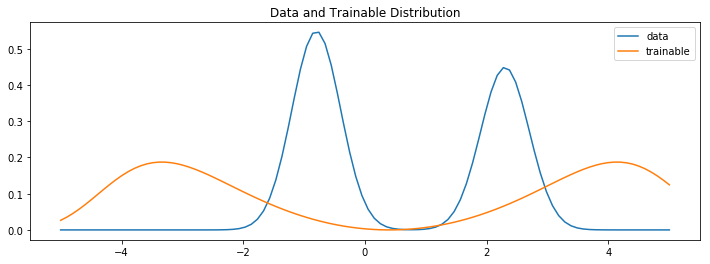

In [61]:
# Plot the data and learned distributions

x = np.linspace(-5, 5, 100)

plt.figure(figsize=(12,4))
plt.plot(x, mix_gauss.prob(x), label='data')
plt.plot(x, trainable_dist.prob(x), label='trainable')
plt.title('Data and Trainable Distribution')
plt.legend()
plt.show()

In [62]:
# Train the bijector

num_epochs = 50
opt = tf.keras.optimizers.Adam()
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    print("Epoch {}...".format(epoch))
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    for train_batch in x_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_inv_cubic.trainable_variables)
            loss = -trainable_dist.log_prob(train_batch)
        train_loss(loss)
        grads = tape.gradient(loss, trainable_inv_cubic.trainable_variables)
        opt.apply_gradients(zip(grads, trainable_inv_cubic.trainable_variables))
    train_losses.append(train_loss.result().numpy())
        
    # Validation
    for valid_batch in x_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())

Epoch 0...
Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...
Epoch 10...
Epoch 11...
Epoch 12...
Epoch 13...
Epoch 14...
Epoch 15...
Epoch 16...
Epoch 17...
Epoch 18...
Epoch 19...
Epoch 20...
Epoch 21...
Epoch 22...
Epoch 23...
Epoch 24...
Epoch 25...
Epoch 26...
Epoch 27...
Epoch 28...
Epoch 29...
Epoch 30...
Epoch 31...
Epoch 32...
Epoch 33...
Epoch 34...
Epoch 35...
Epoch 36...
Epoch 37...
Epoch 38...
Epoch 39...
Epoch 40...
Epoch 41...
Epoch 42...
Epoch 43...
Epoch 44...
Epoch 45...
Epoch 46...
Epoch 47...
Epoch 48...
Epoch 49...


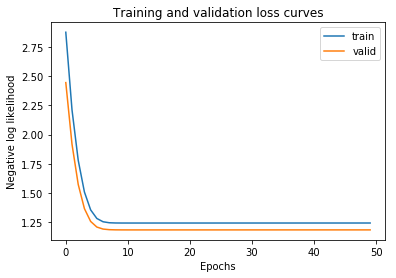

In [63]:
# Plot the learning curves

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

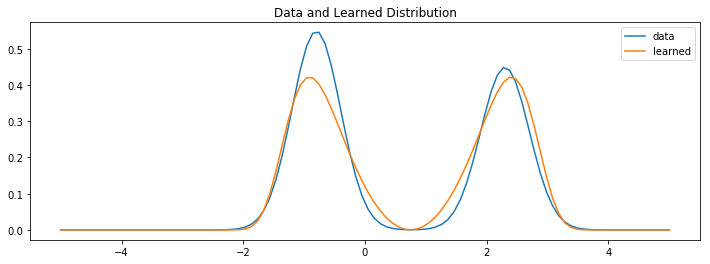

In [64]:
# Plot the data and learned distributions

x = np.linspace(-5, 5, 100)

plt.figure(figsize=(12,4))
plt.plot(x, mix_gauss.prob(x), label='data')
plt.plot(x, trainable_dist.prob(x), label='learned')
plt.title('Data and Learned Distribution')
plt.legend()
plt.show()

In [65]:
# Display trainable variables

trainable_inv_cubic.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.563345>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.42109272>)

***
<a id="coding_tutorial_4"></a>
## Normalising flows

In [66]:
# Load dataset

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
n_samples = 1000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
X_data = StandardScaler().fit_transform(X)
xlim, ylim = [-2, 2], [-2, 2]

(-2, 2)

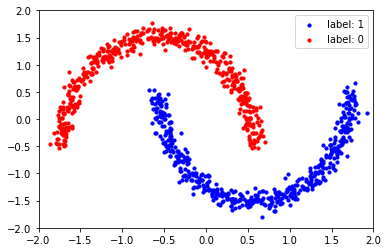

In [67]:
# Plot with labels

y_label = y.astype(np.bool)
X_train, Y_train = X_data[..., 0], X_data[..., 1]
plt.scatter(X_train[y_label], Y_train[y_label], s=10, color='blue')
plt.scatter(X_train[y_label == False], Y_train[y_label == False], s=10, color='red')
plt.legend(['label: 1', 'label: 0'])
plt.xlim(xlim)
plt.ylim(ylim)

In [68]:
# Define base distribution

base_dist = tfd.Normal(loc=0, scale=1)

In [77]:
# Define the trainable distribution

def masked_autoregress_flow(hidden_units=[16, 16], activation='relu'):
    made = tfb.AutoregressiveNetwork(
        params=2,
        event_shape=[2],
        hidden_units=hidden_units,
        activation=activation
    )
    
    mask_auto_flow = tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)
    return mask_auto_flow

trainable_dist = tfd.TransformedDistribution(base_dist,
                                             masked_autoregress_flow(),
                                             event_shape=[2])

In [78]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow.compat.v1 import logging
logging.set_verbosity(logging.ERROR)

In [79]:
# Define a plot contour routine

def plot_contour_prob(dist, rows=1, title=[''], scale_fig=4):
    cols = int(len(dist) / rows)
    xx = np.linspace(-5.0, 5.0, 100)
    yy = np.linspace(-5.0, 5.0, 100)
    X, Y = np.meshgrid(xx, yy)

    fig, ax = plt.subplots(rows, cols, figsize=(scale_fig * cols, scale_fig * rows))
    fig.tight_layout(pad=4.5)

    i = 0
    for r in range(rows):
        for c in range(cols):
            Z = dist[i].prob(np.dstack((X, Y)))
            if len(dist) == 1:
                axi = ax
            elif rows == 1:
                axi = ax[c]
            else:
                axi = ax[r, c]

            # Plot contour
            p = axi.contourf(X, Y, Z)

            # Add a colorbar
            divider = make_axes_locatable(axi)
            cax = divider.append_axes("right", size="5%", pad=0.1)
            cbar = fig.colorbar(p, cax=cax)

            # Set title and labels
            axi.set_title('Filled Contours Plot: ' + str(title[i]))
            axi.set_xlabel('x')
            axi.set_ylabel('y')

            i += 1
    plt.show()

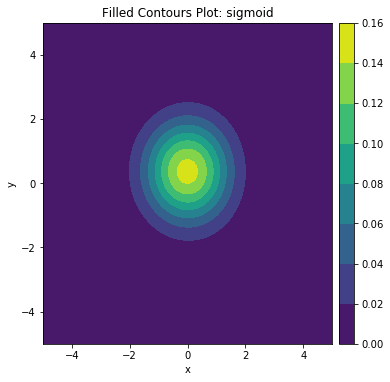

In [82]:
# Plot contour

activation = 'sigmoid'
maf = tfd.TransformedDistribution(base_dist,
                                  masked_autoregress_flow(activation=activation),
                                  event_shape=[2])
plot_contour_prob([maf], scale_fig=6, title=[activation])

In [83]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

In [86]:
# Make samples

x = base_dist.sample((1000, 2))
names = [base_dist.name, trainable_dist.bijector.name]
samples = [x, trainable_dist.bijector.forward(x)]

In [87]:
# Define a scatter plot routine for the bijectors

def _plot(results, rows=1, legend=False):
    cols = int(len(results) / rows)
    f, arr = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            res = results[i]
            X, Y = res[..., 0].numpy(), res[..., 1].numpy()
            if rows == 1:
                p = arr[c]
            else:
                p = arr[r, c]
            p.scatter(X, Y, s=10, color='red')
            p.set_xlim([-5, 5])
            p.set_ylim([-5, 5])
            p.set_title(names[i])
            
            i += 1

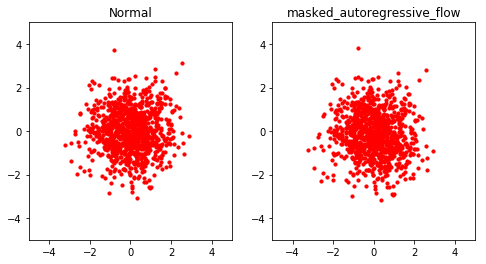

In [88]:
# Plot

_plot(samples)

#### Training a MaskedAutoregressiveFlow bijector

In [89]:
from tensorflow.keras.callbacks import LambdaCallback

In [90]:
# Define a training routine

def train_dist_routine(trainable_distribution, n_epochs=200, batch_size=None, n_disp=100):
    x_ = Input(shape=(2,), dtype=tf.float32)
    log_prob_ = trainable_distribution.log_prob(x_)
    model = Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(),
                  loss=lambda _, log_prob: -log_prob)

    ns = X_data.shape[0]
    if batch_size is None:
        batch_size = ns

    # Display the loss every n_disp epoch
    epoch_callback = LambdaCallback(
        on_epoch_end=lambda epoch, logs: 
                        print('\n Epoch {}/{}'.format(epoch+1, n_epochs, logs),
                              '\n\t ' + (': {:.4f}, '.join(logs.keys()) + ': {:.4f}').format(*logs.values()))
                                       if epoch % n_disp == 0 else False 
    )


    history = model.fit(x=X_data,
                        y=np.zeros((ns, 0), dtype=np.float32),
                        batch_size=batch_size,
                        epochs=n_epochs,
                        validation_split=0.2,
                        shuffle=True,
                        verbose=False,
                        callbacks=[epoch_callback])
    return history

In [91]:
# Train the distribution

history = train_dist_routine(trainable_dist, n_epochs=600, n_disp=50)


 Epoch 1/600 
	 loss: 2.8127, val_loss: 2.8460

 Epoch 51/600 
	 loss: 2.7430, val_loss: 2.7632

 Epoch 101/600 
	 loss: 2.7062, val_loss: 2.7221

 Epoch 151/600 
	 loss: 2.6474, val_loss: 2.6504

 Epoch 201/600 
	 loss: 2.5897, val_loss: 2.5754

 Epoch 251/600 
	 loss: 2.5237, val_loss: 2.4886

 Epoch 301/600 
	 loss: 2.4072, val_loss: 2.3414

 Epoch 351/600 
	 loss: 2.2572, val_loss: 2.1840

 Epoch 401/600 
	 loss: 2.1813, val_loss: 2.1079

 Epoch 451/600 
	 loss: 2.1418, val_loss: 2.0634

 Epoch 501/600 
	 loss: 2.1128, val_loss: 2.0247

 Epoch 551/600 
	 loss: 2.0867, val_loss: 1.9973


In [92]:
# Get losses

train_losses = history.history['loss']
valid_losses = history.history['val_loss']

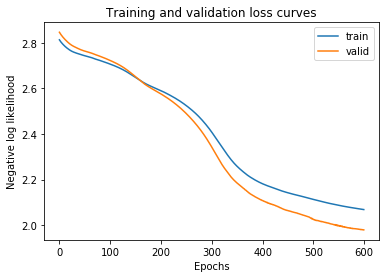

In [93]:
# Plot loss vs epoch

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

In [94]:
# Make samples

x = base_dist.sample((1000, 2))
names = [base_dist.name, trainable_dist.bijector.name]
samples = [x, trainable_dist.bijector.forward(x)]

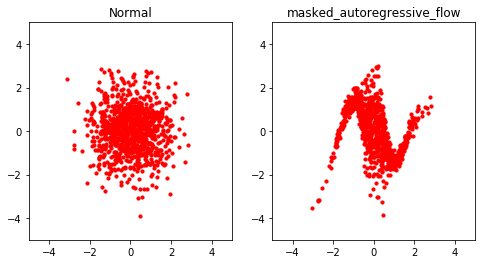

In [95]:
# Plot

_plot(samples)

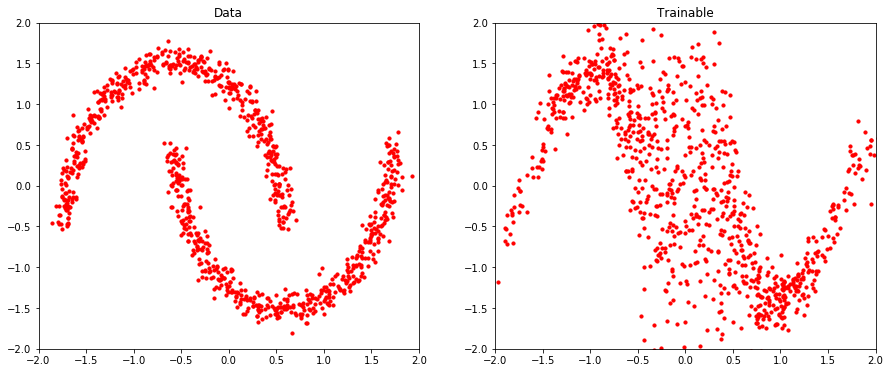

In [96]:
# Define a plot routine

def visualize_training_data(samples):
    f, arr = plt.subplots(1, 2, figsize=(15, 6))
    names = ['Data', 'Trainable']
    samples = [tf.constant(X_data), samples[-1]]

    for i in range(2):
        res = samples[i]
        X, Y = res[..., 0].numpy(), res[..., 1].numpy()
        arr[i].scatter(X, Y, s=10, color='red')
        arr[i].set_xlim([-2, 2])
        arr[i].set_ylim([-2, 2])
        arr[i].set_title(names[i])

visualize_training_data(samples)

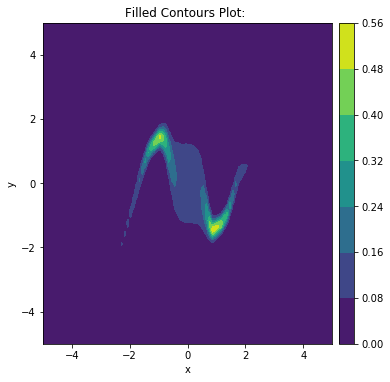

In [98]:
# Plot contour

plot_contour_prob([trainable_dist], scale_fig=6)

#### Training a chain of MaskedAutoregressiveFlow bijectors

In [99]:
# Define a more expressive model

num_bijectors = 6
bijectors = []

for i in range(num_bijectors):
    masked_auto_i = masked_autoregress_flow(hidden_units=[256, 256], activation='relu')
    bijectors.append(masked_auto_i)
    bijectors.append(tfb.Permute(permutation=[1,0]))

flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

In [101]:
# Define the trainable distribution

trainable_dist = tfd.TransformedDistribution(distribution=base_dist,
                                             bijector=flow_bijector,
                                             event_shape=[2])

In [103]:
# Make samples

def make_samples():
    x = base_dist.sample((1000, 2))
    samples = [x]
    names = [base_dist.name]
    for bijector in reversed(trainable_dist.bijector.bijectors):
        x = bijector.forward(x)
        samples.append(x)
        names.append(bijector.name)
    return names, samples

names, samples = make_samples()

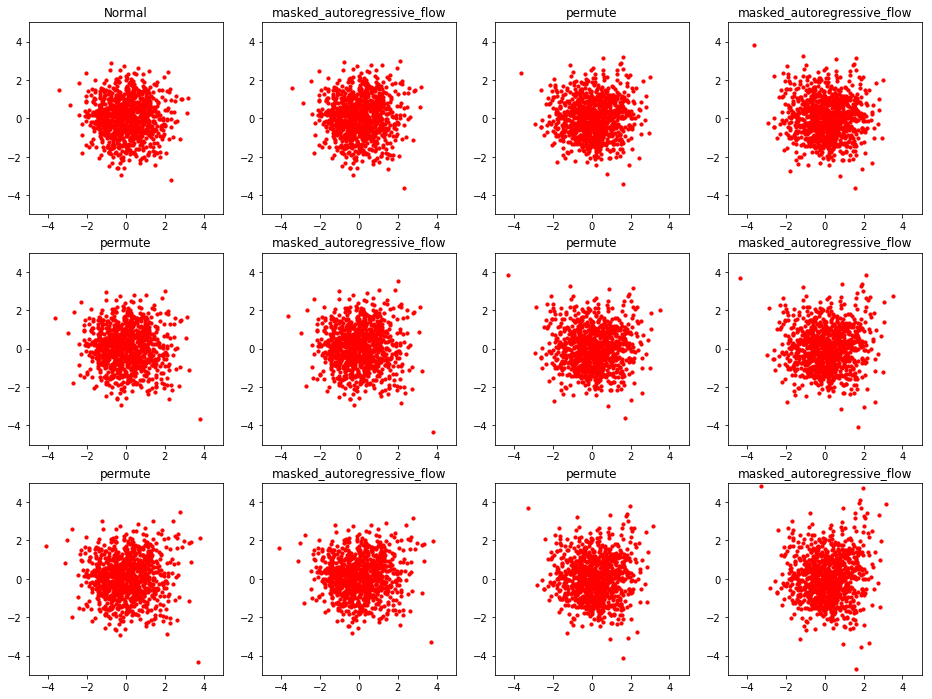

In [105]:
# Plot

_plot(samples, 3)

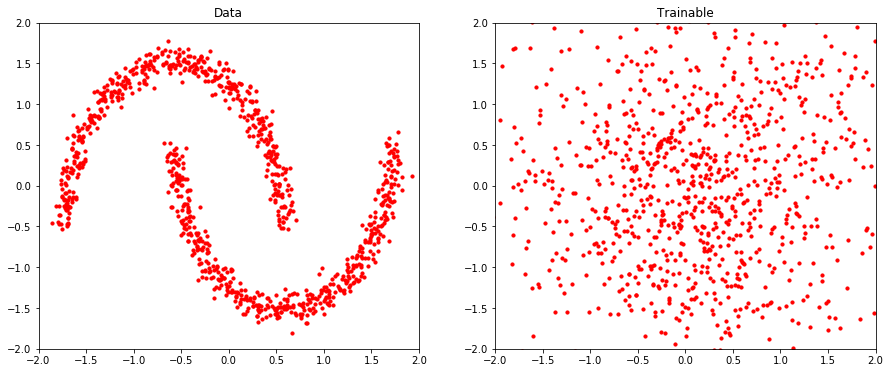

In [106]:
# Plot

visualize_training_data(samples)

In [112]:
# Train the distribution

history = train_dist_routine(trainable_dist, n_epochs=600, n_disp=50)


 Epoch 1/600 
	 loss: 1.5675, val_loss: 696.3580

 Epoch 51/600 
	 loss: 2.3827, val_loss: 2.4616

 Epoch 101/600 
	 loss: 2.0111, val_loss: 2.1123

 Epoch 151/600 
	 loss: 1.7429, val_loss: 1.8768

 Epoch 201/600 
	 loss: 1.4046, val_loss: 1.5581

 Epoch 251/600 
	 loss: 1.2965, val_loss: 1.4849

 Epoch 301/600 
	 loss: 1.2374, val_loss: 1.4506

 Epoch 351/600 
	 loss: 1.2102, val_loss: 1.4428

 Epoch 401/600 
	 loss: 1.1994, val_loss: 1.3935

 Epoch 451/600 
	 loss: 1.1687, val_loss: 1.3894

 Epoch 501/600 
	 loss: 1.1577, val_loss: 1.3710

 Epoch 551/600 
	 loss: 1.1442, val_loss: 1.3584


In [113]:
# Get losses

train_losses = history.history['loss']
valid_losses = history.history['val_loss']

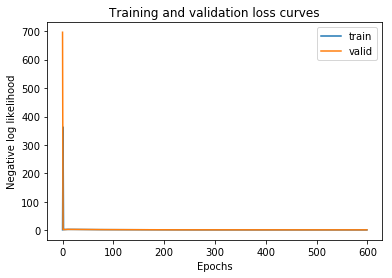

In [114]:
# Plot loss vs epoch

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

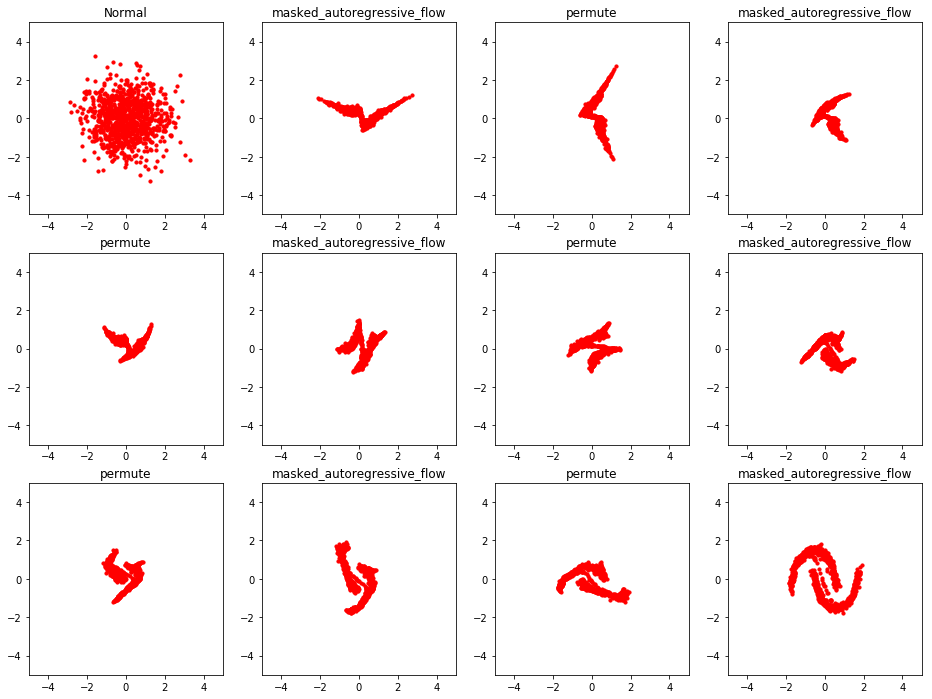

In [115]:
# Make samples and plot

names, samples = make_samples()
_plot(samples, 3)

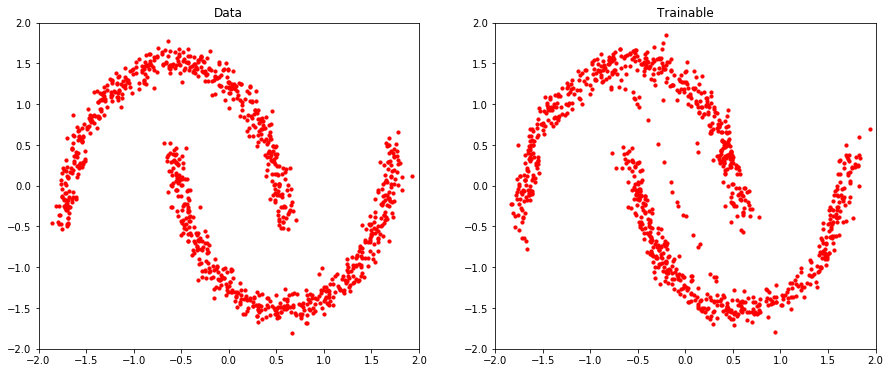

In [116]:
# Plot

visualize_training_data(samples)

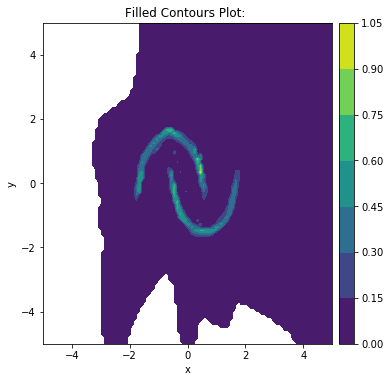

In [118]:
# Plot

plot_contour_prob([trainable_dist], scale_fig=6)